<a href="https://colab.research.google.com/github/bforoura/GENAI26/blob/main/LLM_Text_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How an LLM Generates Text**

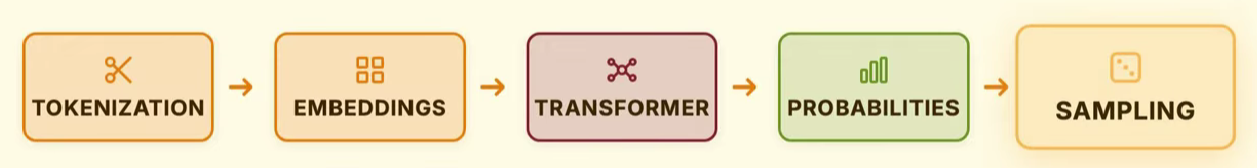

In [1]:
# Install & import the needed libraries

!pip install -q transformers torch

!pip install triton torchao



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 6.5 MB/s eta 0:00:00


# **torch**

This is **PyTorch**, the deep learning framework. It contains support for:

* Tensors, which are similar to nD arrays but much faster with GPU support
* Neural network layers
* GPU acceleration, when/if available
* LLMs, which cannot run without libraries such as PyTorch

# **transformers**

* The Hugging Face Transformers library contains:
  * Pretrained models such as GPT-2, BERT, etc.
  * Tokenizers
  * Model architectures
  * Loading & inference APIs
  * Without this library, we  would have to implement the transformer architecture, load model weights manually, write tokenizers from scratch, etc.

In [2]:
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel


In [3]:
# Load tokenizer & model

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

# **Tokenization**

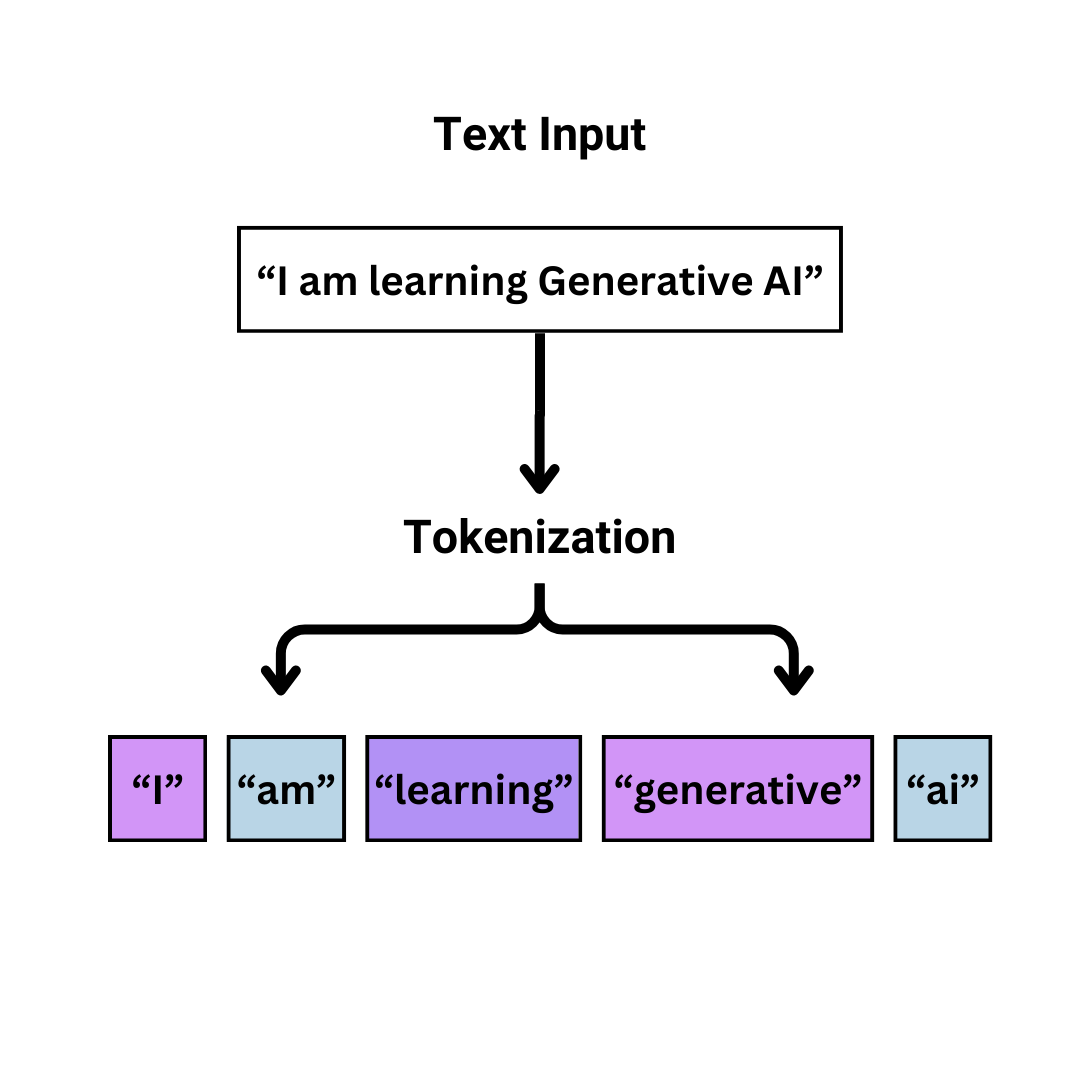

# **Example**


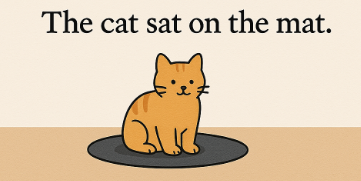

In [4]:
# Enter your own input text

text = input("Enter a sentence: ")


Enter a sentence: The cat sat on the mat


In [5]:
# The tokenization step typically creates subword tokens, and not necessarily whole words

tokens = tokenizer.encode(text, return_tensors="pt")

print("Token IDs:", tokens.tolist()[0])
print("Tokens:")
for tid in tokens[0]:
    print(f"{tid.item():>6} → '{tokenizer.decode(tid)}'")


Token IDs: [464, 3797, 3332, 319, 262, 2603]
Tokens:
   464 → 'The'
  3797 → ' cat'
  3332 → ' sat'
   319 → ' on'
   262 → ' the'
  2603 → ' mat'


# **Embeddings**

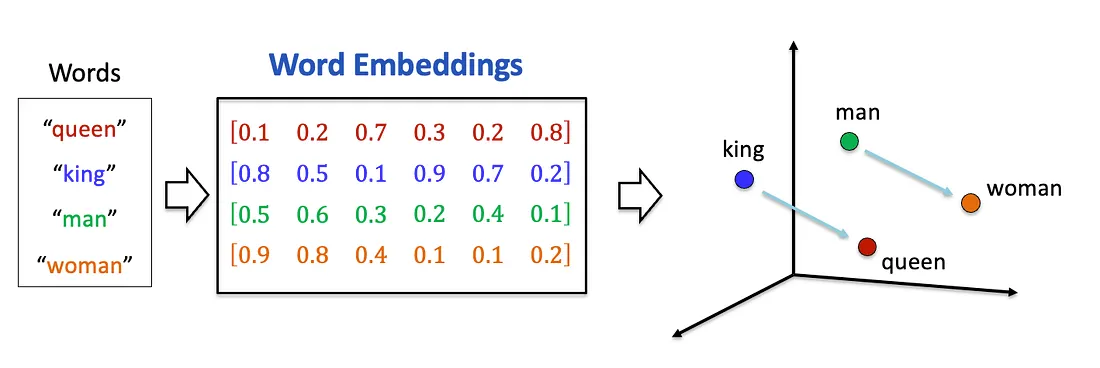
The LLM here (GPT-2) performs subword tokenization:

* **the cat sat on the mat**
* **["the", "Ġcat", "Ġsat", "Ġon", "Ġthe", "Ġmat"]**
* where, **Ġ** keeps track of the space before a token

The model does not see words but rather token IDs:
* **[464, 3797, 3332, 319, 262, 2603]**

Each token ID is then mapped to an nD vector (n=3 here for illustration):
* "the"  → [ 0.2, -0.1,  0.7 ]
* "cat"  → [ 1.1,  0.9, -0.3 ]
* "sat"  → [ 0.8,  0.4,  0.2 ]
* "on"   → [ 0.1, -0.2,  0.5 ]
* "the"  → [ 0.2, -0.1,  0.7 ]
* "mat"  → [ 0.9,  0.6, -0.1 ]

These vectors encode:
* **Meaning**
* **Usage patterns**
* **Statistical relationships**

So “cat” and “mat” end up closer to each other than to “the”.

In [6]:
# The embeddings

with torch.no_grad():
    # Token embeddings
    token_embeds = model.transformer.wte(tokens)

    # Positional embeddings
    positions = torch.arange(tokens.size(1)).unsqueeze(0)
    pos_embeds = model.transformer.wpe(positions)

    embeddings = token_embeds + pos_embeds

# (batch_size, sequence_length, embedding_dim)
print("Embedding shape:", embeddings.shape)


Embedding shape: torch.Size([1, 6, 768])


# **The Transformer**

* The transformer forward pass ensures that each token now contains contextual information from previous tokens.

* This is the most important step conceptually, because this is where the model goes from isolated words to understanding a sentence.

* Before the transformer step, each vector means: “I am token X at position Y”
* After the transformer step, each vector means: “I am token X at position Y, with awareness of **previous tokens**”
  * i.e., "**sat**" knows it follows "**the cat**" or the token "**cat**" attends to "**mat**" in some attention heads

* **GPT-2** (the small/base model) has 12 transformer layers with 12 attention heads per layer. So in total, it has 144 attention heads

* Every attention head in a layer learns to focus on different kinds of relationships between tokens.
  * **Syntactic dependencie**s: subject → verb (“cat → sat”)
  * **Local grammatical patterns**: prepositions, determiners
  * **Semantic associations**: “cat → mat” or “dog → bone”
  * **Long-range dependencies**: pronoun references, repeated tokens


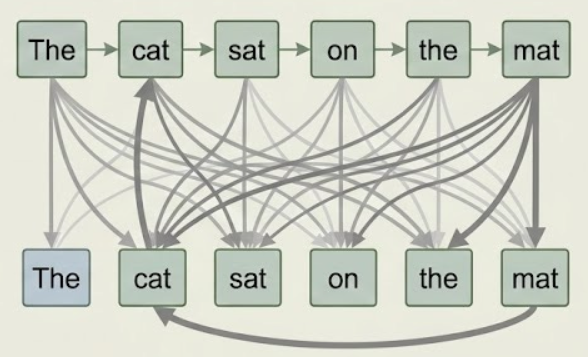

In [7]:
# The transformer forward pass ensures that each token now contains contextual information from previous tokens.
# This is the most important step conceptually, because this is where the model goes from isolated words to understanding a sentence.

with torch.no_grad():

    # Send the embedding vectors through all transformer layers (for GPT-2, it is 12 layers)
    outputs = model.transformer(inputs_embeds=embeddings)

    # Each layer, applies the self-attention mechanism and goes through a feed-forward NN
    hidden_states = outputs.last_hidden_state

print("Hidden state shape:", hidden_states.shape)


Hidden state shape: torch.Size([1, 6, 768])


In [8]:
# Logits for the next token. This gives one score per vocabulary token (~50k tokens)

with torch.no_grad():
    last_hidden = hidden_states[:, -1, :]
    logits = model.lm_head(last_hidden)

print("Logits shape:", logits.shape)


Logits shape: torch.Size([1, 50257])



# **Softmax and Probabilities**

* In LLMs, the output layer spans the entire vocabulary.
* In a traditional classification model predicts the class with the highest softmax score, which makes it deterministic.

* But LLMs sample the prediction from these softmax probabilities:

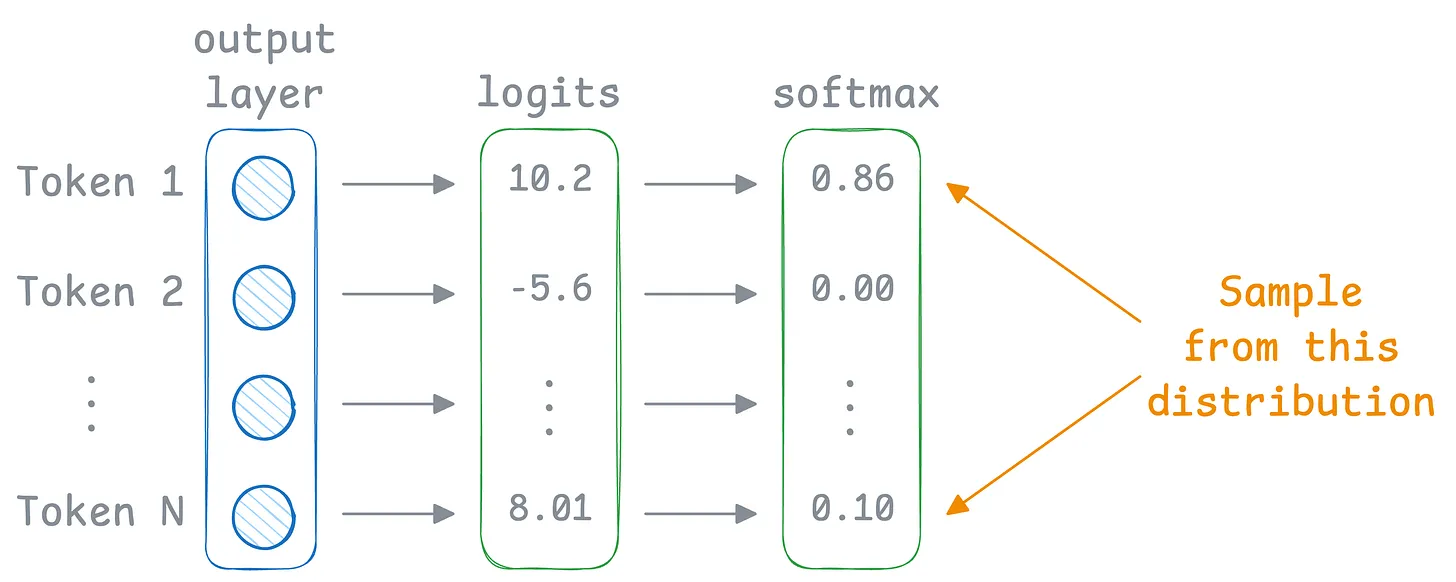

In [9]:
# Softmax → probabilities: this is the actual probability distribution the model uses

probs = F.softmax(logits, dim=-1)

top_probs, top_ids = torch.topk(probs, k=10)

print("Top 10 next-token probabilities:")
for p, tid in zip(top_probs[0], top_ids[0]):
    token = tokenizer.decode(tid)
    print(f"{token!r:>12} : {p.item():.4f}")


Top 10 next-token probabilities:
         ',' : 0.3431
      ' and' : 0.1995
         '.' : 0.1096
       ' in' : 0.0696
     ' with' : 0.0564
      ' for' : 0.0453
       ' as' : 0.0189
       ' on' : 0.0145
    ' while' : 0.0136
       ' at' : 0.0098


# **Temperature**

* Even though “Token 1” has the highest probability of being selected, it may not be chosen as the next token since we are sampling.

* **Temperature** introduces the following tweak in the softmax function, which, in turn, influences the sampling process:

  * If the **temperature is low**, the probabilities look more like a max value instead of a “**soft-max**” value.
  * If the **temperature is high**, the probabilities start to look like a **uniform distribution**, i.e., the sampling process may select any token. This makes the generation process random and heavily stochastic


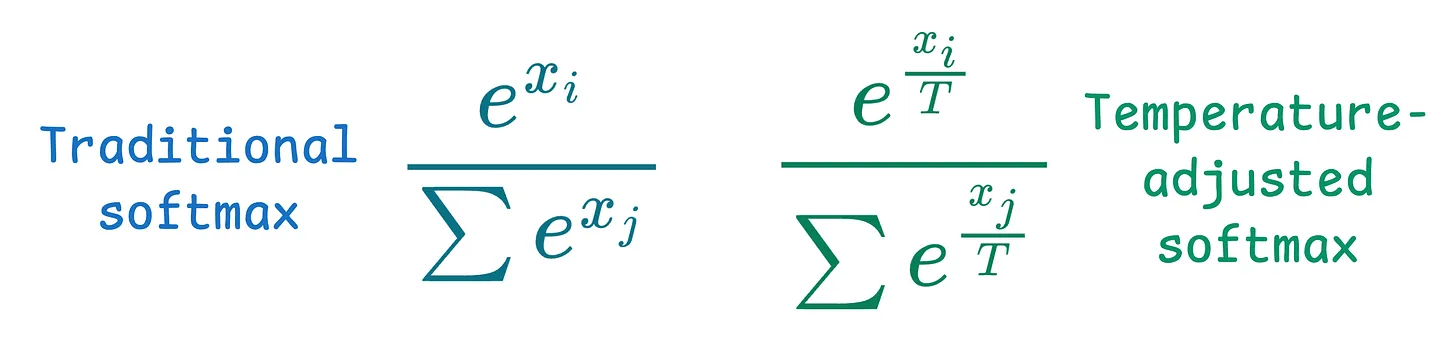

# **Sampling**

* **Greedy Search**: The token with the **highest probability** from the distribution will be selected as the next token.

* **Random Sampling**: Randomly selects the next token from the probability distribution. Two key concepts in random sampling are **top-k** and **top-p**.

 * **Top-k** limits the model to choosing a token randomly from only the top-k tokens with the highest probability. A top-k value equal to 1 acts as greedy search.

 * **Top-p** limits the model to randomly sampling from the set of tokens whose cumulative probabilities do not exceed a given threshold, starting from the highest probability and working downward.

 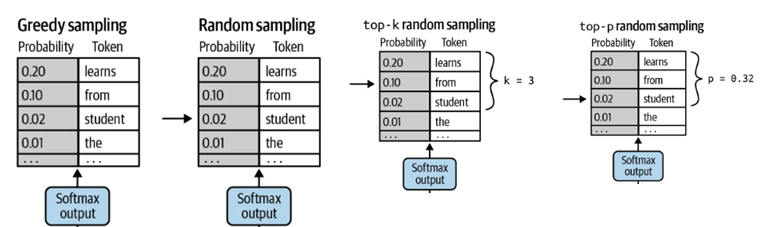


In [10]:
# Sampling (temperature + top-k)

#    temperature = 0.2 (Set a low temperature value to generate predictable responses)
#    temperature = 1.5 (Set a high temperature value to generate more random and creative responses)
#    top_k = None (full distribution)

def sample_next_token(logits, temperature=1.2, top_k=50):
    logits = logits / temperature

    if top_k is not None:
        values, indices = torch.topk(logits, top_k)
        probs = F.softmax(values, dim=-1)
        choice = torch.multinomial(probs, 1)
        return indices[0, choice]
    else:
        probs = F.softmax(logits, dim=-1)
        return torch.multinomial(probs, 1)

next_token_id = sample_next_token(logits, temperature=0.8, top_k=40)
print("Sampled token:", tokenizer.decode(next_token_id[0]))


Sampled token: ,


In [15]:
# Full loop (generate multiple tokens)

def generate_step_by_step(prompt, steps=10):
    tokens = tokenizer.encode(prompt, return_tensors="pt")

    for _ in range(steps):
        with torch.no_grad():
            outputs = model(tokens)
            logits = outputs.logits[:, -1, :]
            next_token = sample_next_token(logits, temperature=0.8, top_k=40)

        tokens = torch.cat([tokens, next_token], dim=1)
        print(tokenizer.decode(tokens[0]))

generate_step_by_step(text, steps=10)


The cat sat on the mat beside
The cat sat on the mat beside the
The cat sat on the mat beside the bed
The cat sat on the mat beside the bed,
The cat sat on the mat beside the bed, its
The cat sat on the mat beside the bed, its head
The cat sat on the mat beside the bed, its head raised
The cat sat on the mat beside the bed, its head raised in
The cat sat on the mat beside the bed, its head raised in the
The cat sat on the mat beside the bed, its head raised in the air
